# Overshooting heatmaps

Using the NEW metric (one for each 0.25° grid point)


In [1]:
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts/")
import pickle

import xarray as xr
import numpy as np
import model_grid as mg
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec


In [2]:
freq_dir = "/work/bb1153/b380887/global_tropics/os_frequencies/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/new_osc_metric/"


In [7]:
model_list = ["OBS", "SHIELD", "SCREAM", "GEOS", "SAM", "ICON"]
# model_list = ["SAM"]

In [11]:
varname_dict = {
    "SHIELD": "rlut",
    "GEOS": "rlut",
    "SCREAM": "rlt",
    "SAM": "rlt",
    "ICON": "rlt",
    "OBS": "Tb",
}


### Get the native 3 hourly overshooting frequencies

In [22]:
def interp_var2d(var2d, model, coords=[0, 360, -30, 10], region="TWP",
                 scream_coords="/home/disk/eos7/jnug/cold-point-overshoot/pickle_files/coord_csvs/",
                ):
    """
    Interp cell var (no time dim) onto lat/lon
    """
    if model == "GEOS":
        print("Interpolating GEOS")
        
            
        var_interp_vals = mg.interpolate_grid(var2d, is3D=False, data_array=True,
                                              clat=var2d.lats, clon=var2d.lons,
                                              latlims=coords[2:], lonlims=coords[:2],
                                              to_180=False, )#print_progress=False)
        var2d_interp = xr.DataArray(var_interp_vals[0], dims=["lat", "lon"],
                                    coords={"lon": var_interp_vals[1], "lat": var_interp_vals[2]}) 

    elif model == "ICON":
        print("Interpolating ICON")
        lonlims = coords[:2]

        var_interp_vals = mg.interpolate_grid(var2d, is3D=False, data_array=True,
                                                clat=var2d.clat.values, clon=var2d.clon.values,
                                                latlims=coords[2:], lonlims=(-180, 180),
                                                to_180=True, radians=True,# print_progress=False
                                               )
        var2d_interp = xr.DataArray(var_interp_vals[0], dims=["lat", "lon"],
                                    coords={"lon": var_interp_vals[1], "lat": var_interp_vals[2]}) 

    elif model == "SCREAM":
        print("Interpolating SCREAM")
        itcz_coords_file = "/home/b/b380887/cold-point-overshoot/pickle_files/coord_csvs/SCREAM_coords_ITCZ.csv"
        var_interp_vals = mg.interpolate_grid(var2d, is3D=False, data_array=True,
                                              coords_file=itcz_coords_file, latlims=coords[2:],
                                              lonlims=coords[:2], to_180=False, ) #print_progress=False)
        var2d_interp = xr.DataArray(var_interp_vals[0], dims=["lat", "lon"],
                                    coords={"lon": var_interp_vals[1], "lat": var_interp_vals[2]})

    elif model.upper() == "SHIELD":
        print("Interpolating SHIELD")
        var_interp_vals = mg.interpolate_grid(var2d, is3D=False, data_array=True,
                                              clat=var2d.lat, clon=var2d.lon,
                                              latlims=coords[2:], lonlims=coords[:2],
                                              to_180=False, radians=True, #print_progress=False
                                             )
        var2d_interp = xr.DataArray(var_interp_vals[0], dims=["lat", "lon"],
                                    coords={"lon": var_interp_vals[1], "lat": var_interp_vals[2]}) 

    return var2d_interp


In [23]:
%%time

# os_freqs_dict = {}

# for model in model_list:
for model in ["GEOS", "SAM", "ICON"]:
    if model == "OBS":
        os_freqs = xr.open_dataset(freq_dir + "{m}_os_freq_Tb_new_thresh_dt9K.nc".format(m=model))[varname_dict[model]]
    else:
        os_freqs = xr.open_dataset(freq_dir + "{m}_os_freq_Tb_new_thresh.nc".format(m=model))[varname_dict[model]]
        if model != "SAM":
            os_freqs = interp_var2d(os_freqs, model)
        
    os_freqs_dict[model] = os_freqs
        

Interpolating GEOS
Creating dummy grid...
687985 grid points (4.46%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.
Interpolating ICON
Creating dummy grid...
317030 grid points (1.12%) will be lost from interpolation.
Dummy grid done.
Interpolating data...
Interpolation done.
CPU times: user 1min 11s, sys: 4.48 s, total: 1min 16s
Wall time: 1min 24s


#### For obs - for the dummy metric (using prescribed dts)

In [ ]:
os_freqs_dict = {}
dt_list = np.arange(-2, 15, 2)

for dt in dt_list:
    os_freqs_dict[dt] = xr.open_dataset(freq_dir + "OBS_os_freq_Tb_new_thresh_dt{d}K.nc".format(d=dt))["Tb"]
    

## Plot

In [16]:
def get_lonlat_labs(lons, lats, print_labs=False):
    """ Get string labels for lat & lon plots (deg N/S/E/W)
    """
    lats_lab = [str(abs(x)) for x in lats]
    lons_lab = [str(abs(x)) for x in lons]

    for i, lon in enumerate(lons):
        if lon == 0 or abs(lon) == 180:
            lons_lab[i] += "°"
        elif lon < 0:
            lons_lab[i] += "° W"
        elif lon > 0:
            lons_lab[i] += "° E"

    for i, lat in enumerate(lats):
        if lat < 0:
            lats_lab[i] += "° S"
        elif lat > 0:
            lats_lab[i] += "° N"
        else:
            lats_lab[i] += "°"
            
    if print_labs:
        print(lons_lab)
        print(lats_lab)
        
    return lons_lab, lats_lab


In [17]:
plot_lons = np.arange(-180, 181, 40)
plot_lats = np.arange(-30, 10, 10)
lons_labs, lats_labs = get_lonlat_labs(plot_lons, plot_lats, print_labs=True)


['180°', '140° W', '100° W', '60° W', '20° W', '20° E', '60° E', '100° E', '140° E', '180°']
['30° S', '20° S', '10° S', '0°']


In [28]:
def plot_Tb_heatmap(os_freqs, name, dt=None, levels=None, plot_colorbar=False, cmap="inferno_r", save_dir=save_dir,
                    mask_zero=True, fsize=20, tsize=24, labsize=18, vmin=0, vmax=5, figsize=(16, 4), 
                    extra_save_text=None, save=False):
    """Plot the heatmap after it's been calculated. pct_below_thresh is a DataArray
    """
    mean_pct = os_freqs.mean().values*100.
    if levels is None:
        levels = np.arange(0, 1.1, .1)
        
    if mask_zero:
        plot_pct = os_freqs.where(os_freqs > 0).values*100.
    else:
        plot_pct = os_freqs.values*100.
    
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 6, height_ratios=[1, 0.1], hspace=0.15)
    ax1 = plt.subplot(gs[0, :], projection=ccrs.PlateCarree())
    ax2 = plt.subplot(gs[1, 1:5])

    # cf1 = ax1.pcolormesh(os_freqs.lon, os_freqs.lat, plot_pct, cmap=cmap,
    #                      vmin=vmin, vmax=vmax)
    cf1 = ax1.contourf(os_freqs.lon, os_freqs.lat, plot_pct, cmap=cmap,
                         levels=levels, extend="max")
    ax1.set_title("{n} (avg={p:.2f}%)".format(n=name, p=mean_pct), fontsize=fsize, loc="center")
    if name == "SHIELD":
        ax1.set_title("SHiELD", fontsize=tsize, loc="center")
    # elif name == "OBS":
    #     ax1.set_title("OBS (offset = {} K)".format(dt), fontsize=tsize, loc="center")
    else:
        ax1.set_title("{m}".format(m=name), fontsize=tsize, loc="center")

    ax1.set_xticks(plot_lons)
    ax1.set_xticklabels(lons_labs, fontsize=labsize)
    ax1.set_yticks(plot_lats)
    ax1.set_yticklabels(lats_labs, fontsize=labsize)
    ax1.add_feature(cfeature.BORDERS)
    ax1.add_feature(cfeature.COASTLINE)
        
    if plot_colorbar:
        cbar = plt.colorbar(cf1, cax=ax2, orientation="horizontal", extend="max")
        cbar.set_label("Pointwise frequency of cold point overshoots (%)", fontsize=fsize)
        cbar.ax.tick_params(labelsize=labsize+4)
    else:
        ax2.axis("off")

    if save:
        if "SAM" in name:
            save_name = "Sa"
        elif "SCREAM" in name:
            save_name = "Sr"
        elif "SHiELD" in name or "SHIELD" in name:
            save_name = "Sh"
        else:
            save_name = name[0]
            
        if extra_save_text is None:
            plt.savefig(save_dir + "{n}_os_heatmap_Tb_3hrly_new_thresh.png".format(n=save_name),
                        bbox_inches="tight", dpi=300)
        else:
            plt.savefig(save_dir + "{n}_os_heatmap_Tb_3hrly_new_thresh_dt{d}K_{e}.png".format(n=save_name, d=dt, e=extra_save_text),
                        bbox_inches="tight", dpi=300)

    plt.show()

    

### With obs & all models

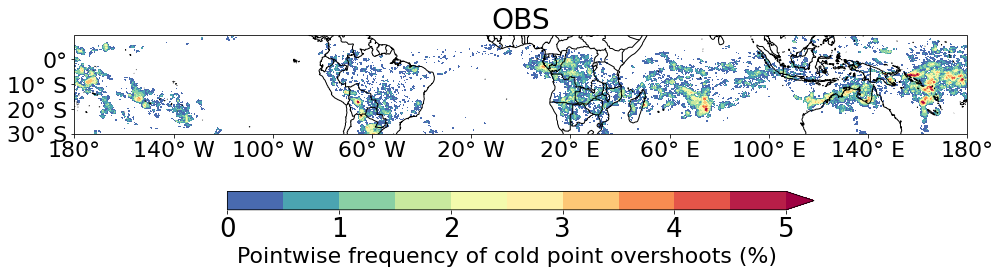

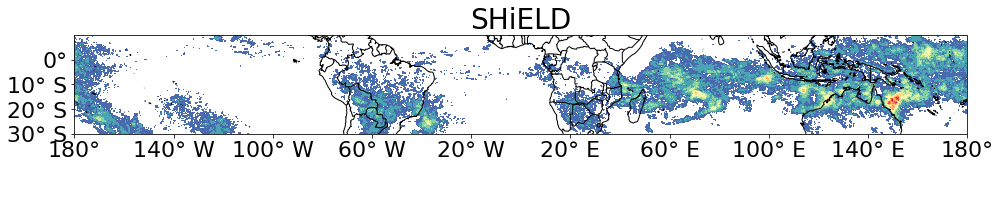

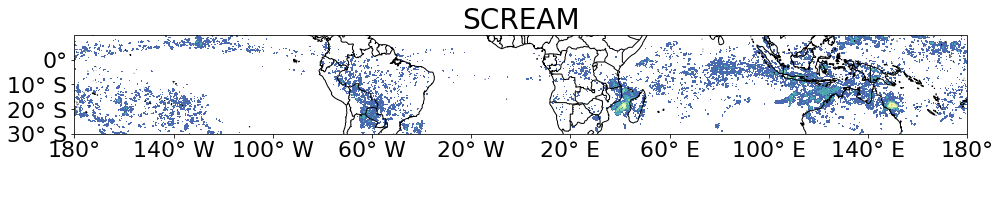

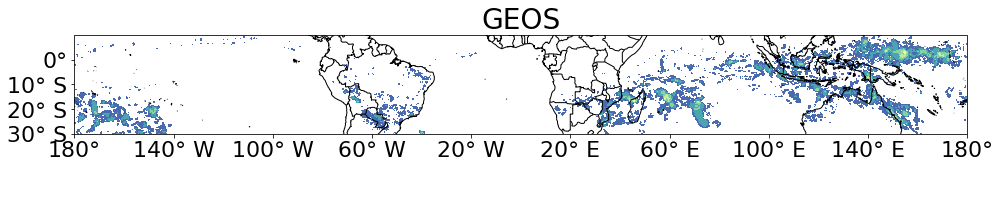

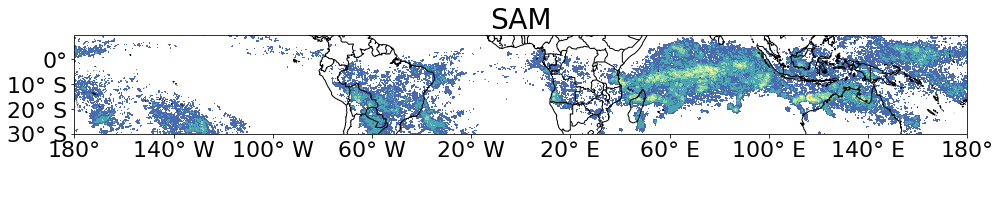

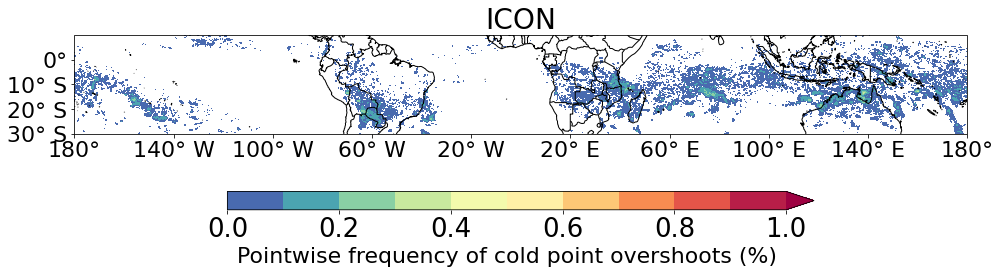

CPU times: user 2min 35s, sys: 4.62 s, total: 2min 39s
Wall time: 2min 37s


In [30]:
%%time

for model in model_list:
    if model == "ICON" or model == "OBS":
        plot_colorbar = True
    else:
        plot_colorbar = False
    if model == "OBS":
        plot_Tb_heatmap(os_freqs_dict[model], model, plot_colorbar=True, levels=np.arange(0, 5.1, 0.5),
                        cmap="Spectral_r", fsize=22, tsize=28, labsize=22, save=True)
    else:
        plot_Tb_heatmap(os_freqs_dict[model], model, plot_colorbar=plot_colorbar,
                        cmap="Spectral_r", fsize=22, tsize=28, labsize=22, save=True)


#### Trying it for obs - using specified values for dT to get the threshold

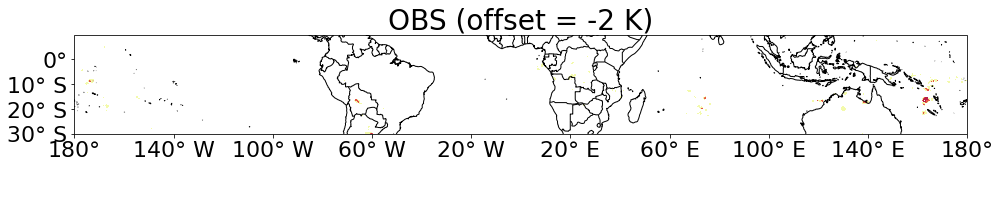

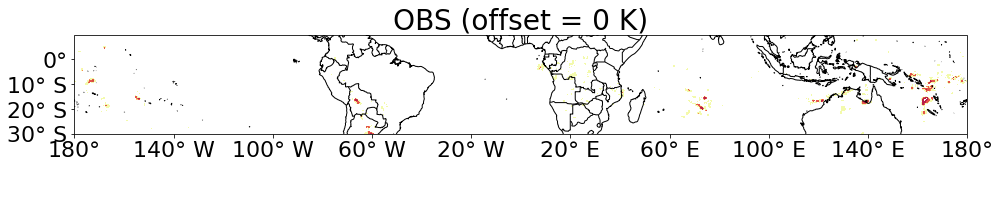

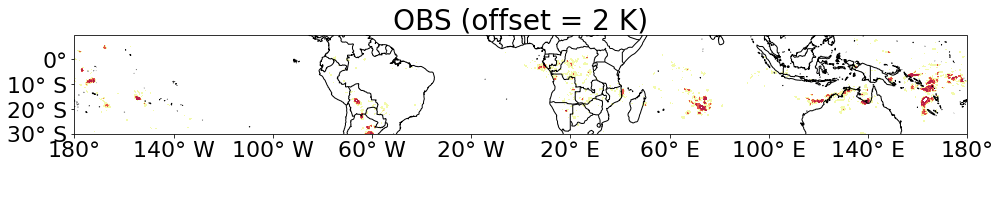

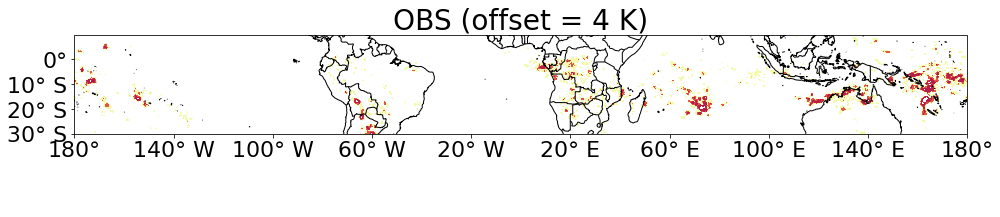

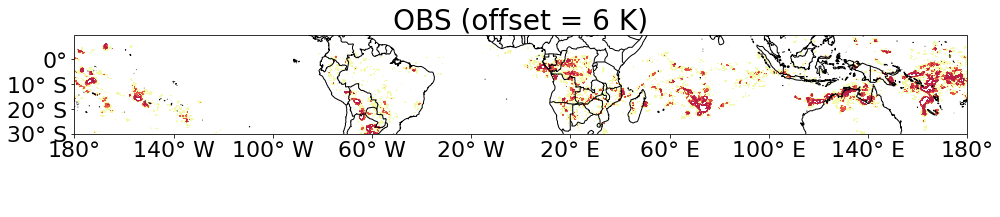

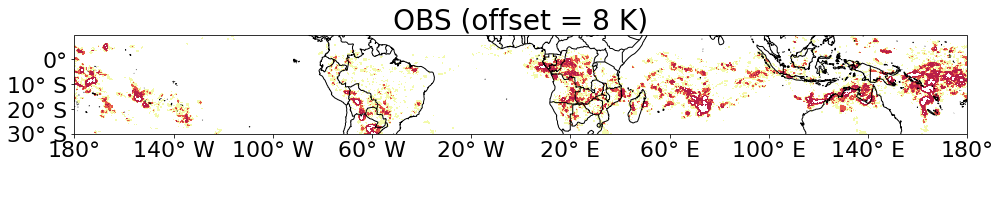

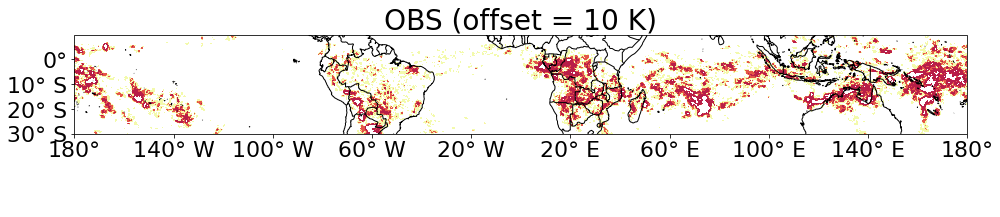

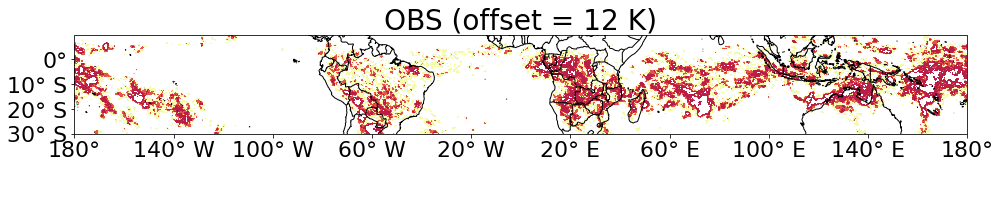

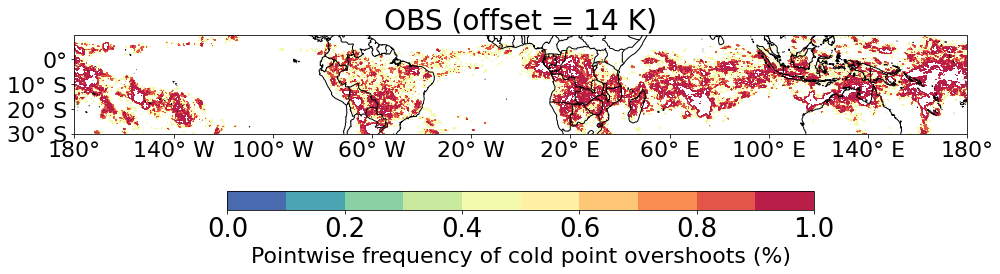

In [19]:
for dt in dt_list:
    if dt == 14:
        plot_colorbar = True
    else:
        plot_colorbar = False
    plot_Tb_heatmap(os_freqs_dict[dt], "OBS", dt, plot_colorbar=plot_colorbar, levels=np.arange(0, 1.1, .1),
                    cmap="Spectral_r", fsize=22, tsize=28, labsize=22, save=True, extra_save_text="obs")


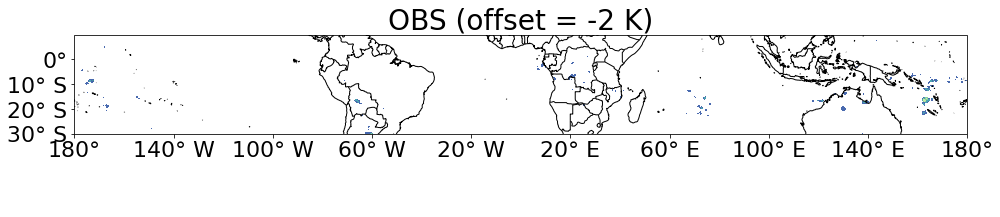

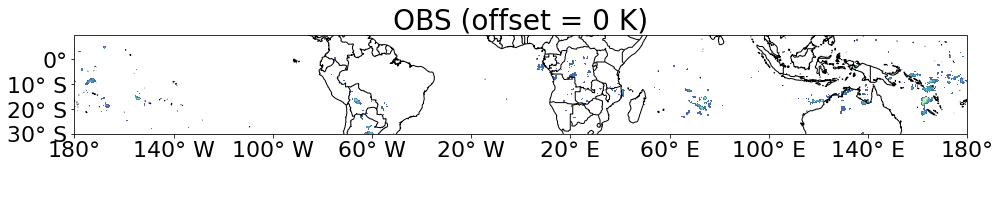

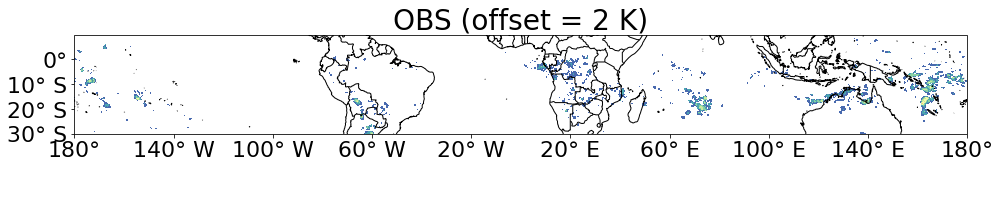

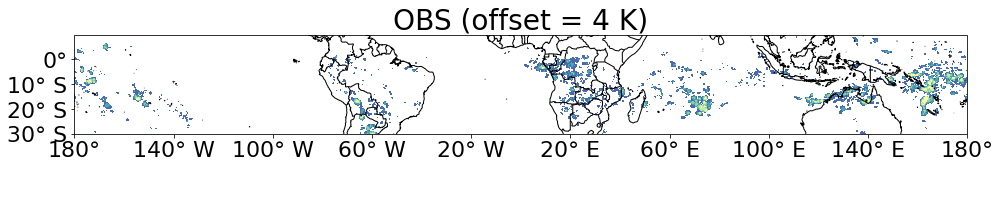

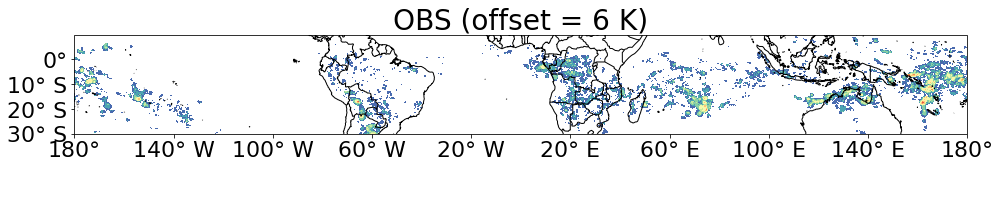

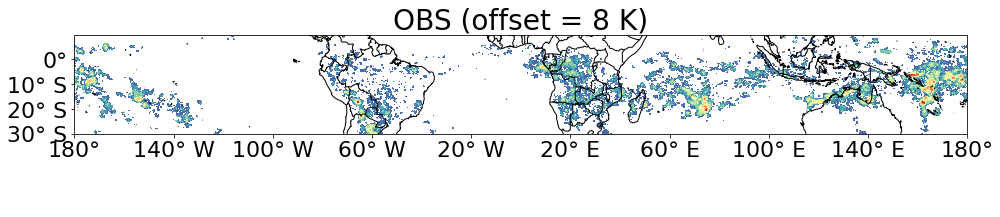

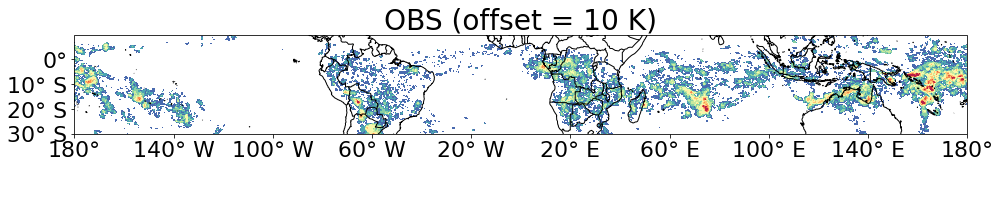

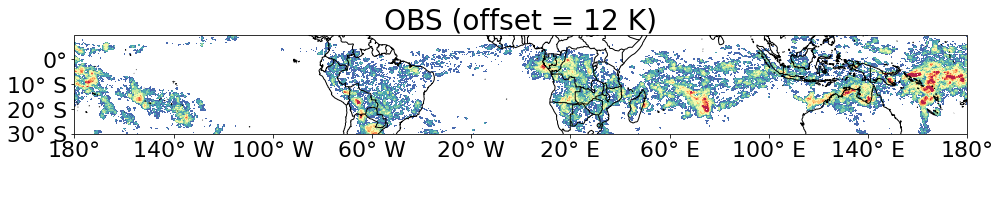

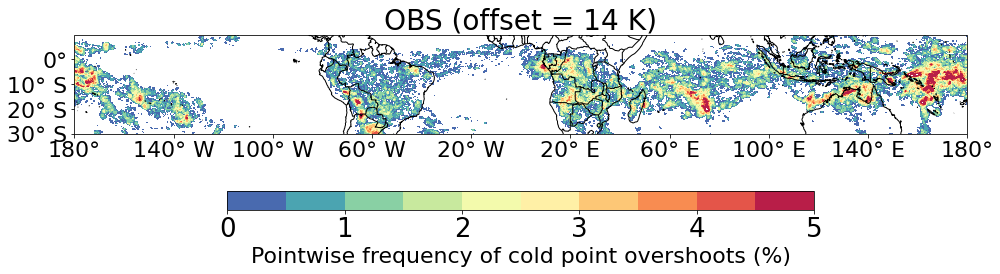

In [16]:
# trying it with a wider colorscale
obs_levs = np.arange(0, 5.1, 0.5)

for dt in dt_list:
    if dt == 14:
        plot_colorbar = True
    else:
        plot_colorbar = False
    plot_Tb_heatmap(os_freqs_dict[dt], "OBS", dt, plot_colorbar=plot_colorbar, levels=obs_levs,  
                    cmap="Spectral_r", fsize=22, tsize=28, labsize=22, 
                    extra_save_text="diff_colorscale", save=True)


##### Redoing SAM after fixing the frequency interp stuff

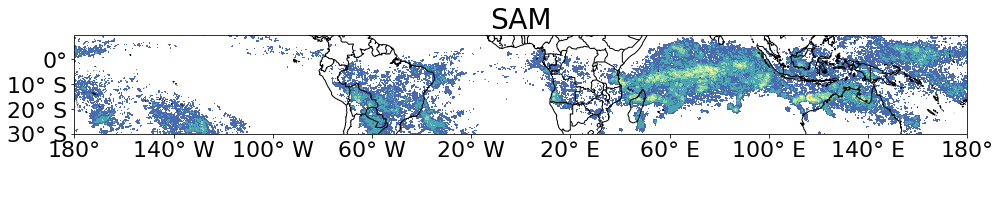

CPU times: user 14.3 s, sys: 808 ms, total: 15.1 s
Wall time: 14.9 s


In [11]:
%%time

for model in model_list:
    if model == "ICON":
        plot_colorbar = True
    else:
        plot_colorbar = False
    plot_Tb_heatmap(os_freqs_dict[model], model, plot_colorbar,
                    cmap="Spectral_r", fsize=22, tsize=28, labsize=22, save=True)


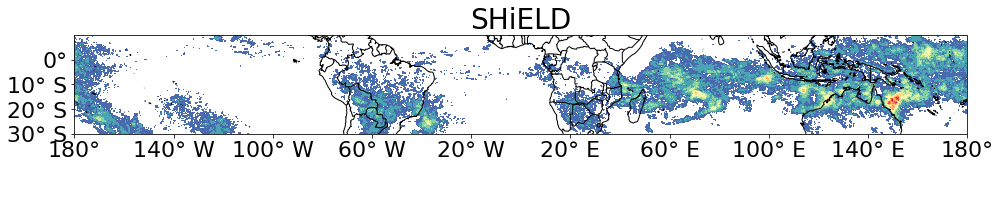

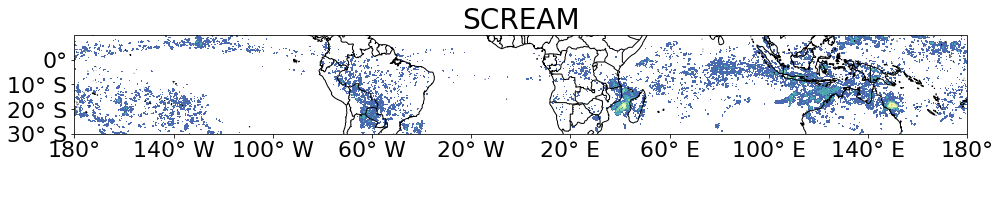

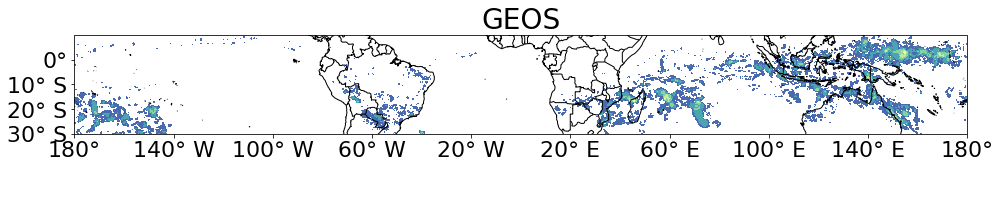

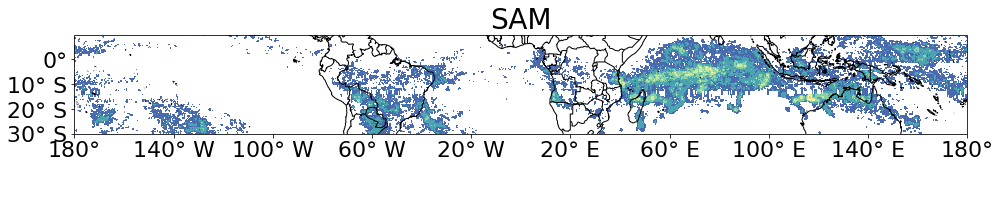

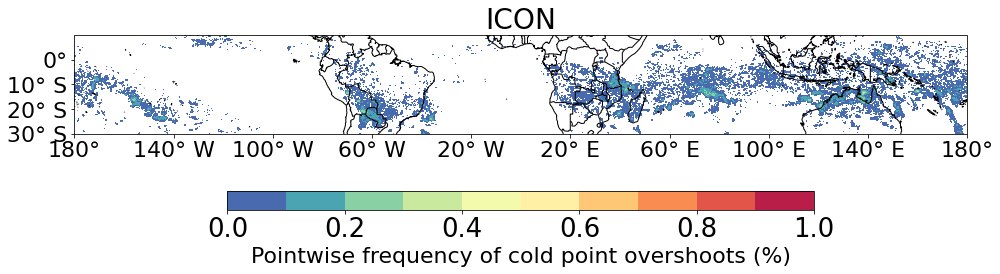

CPU times: user 2min 21s, sys: 3.6 s, total: 2min 25s
Wall time: 2min 23s


In [15]:
%%time

for model in model_list:
    if model == "ICON":
        plot_colorbar = True
    else:
        plot_colorbar = False
    plot_Tb_heatmap(os_freqs_dict[model], model, plot_colorbar,
                    cmap="Spectral_r", fsize=22, tsize=28, labsize=22, save=True)


### Old versions

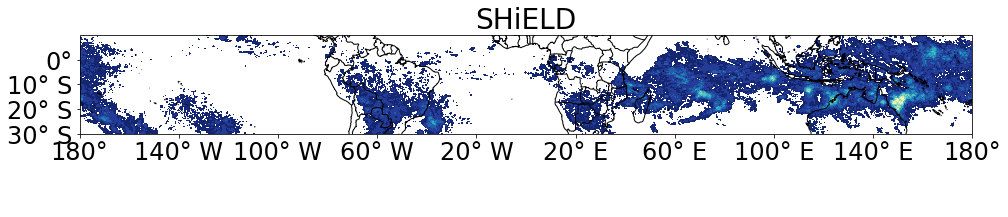

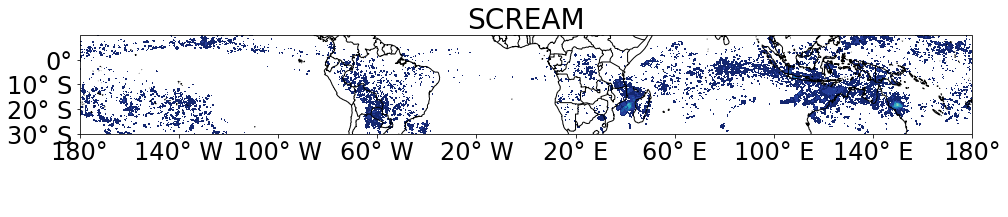

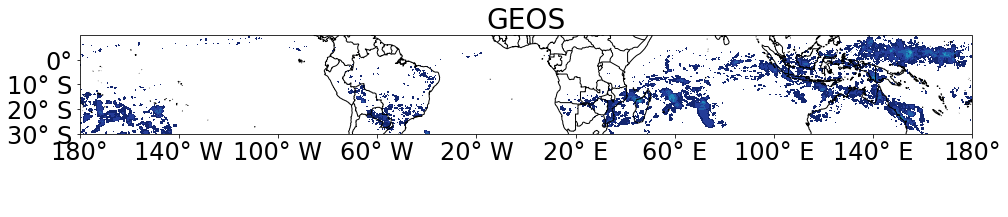

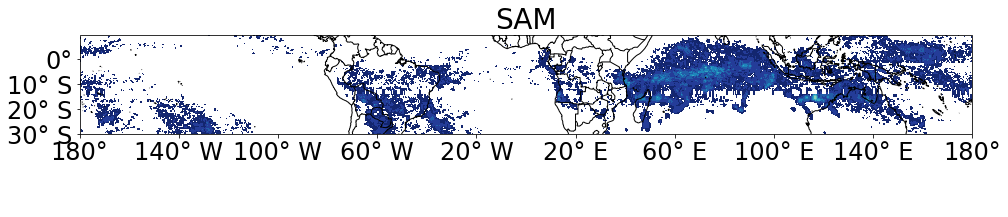

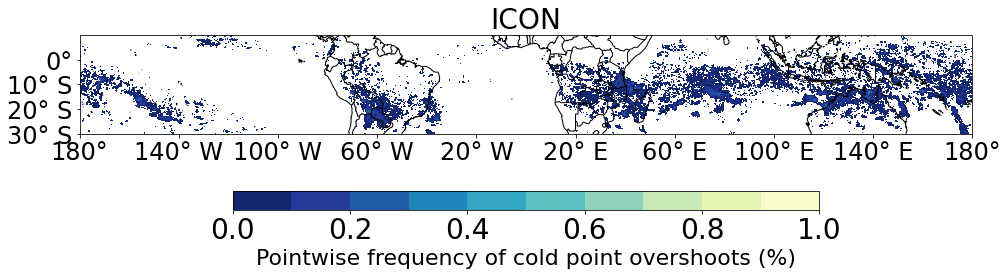

CPU times: user 2min 21s, sys: 3.6 s, total: 2min 25s
Wall time: 2min 23s


In [13]:
%%time

for model in model_list:
    if model == "ICON":
        plot_colorbar = True
    else:
        plot_colorbar = False
    plot_Tb_heatmap(os_freqs_dict[model], model, plot_colorbar,
                    cmap="YlGnBu_r", fsize=22, tsize=28, labsize=24, vmin=0, vmax=0.5, save=True)


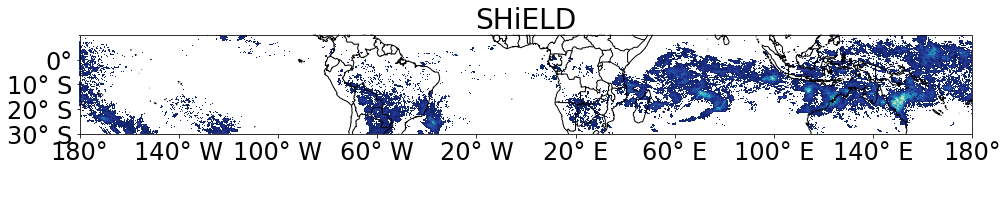

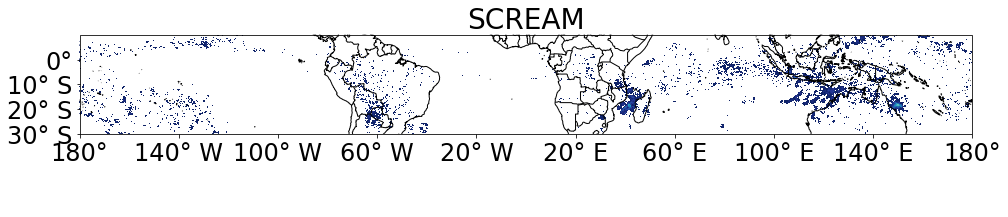

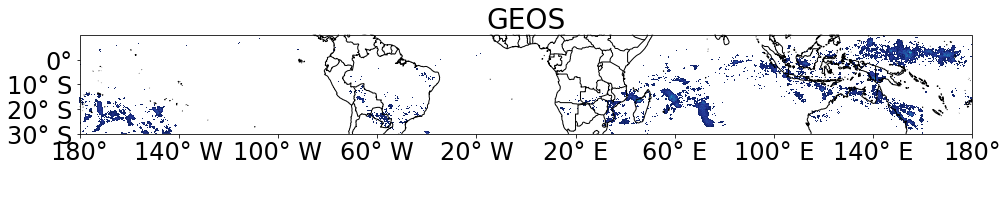

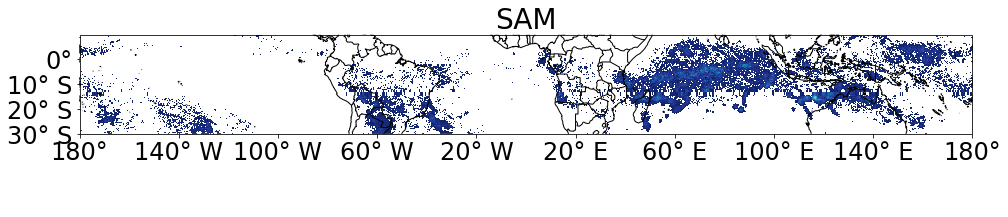

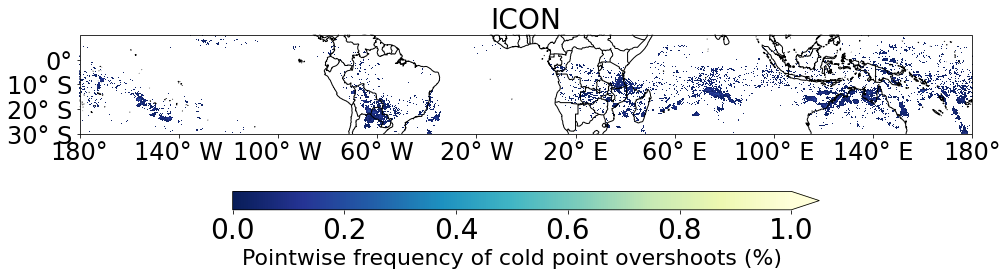

CPU times: user 41 s, sys: 12.3 s, total: 53.3 s
Wall time: 52.4 s


In [15]:
%%time

# version with pcolormesh

for model in model_list:
    if model == "ICON":
        plot_colorbar = True
    else:
        plot_colorbar = False
    plot_Tb_heatmap(os_freqs_dict[model], model, plot_colorbar,
                    cmap="YlGnBu_r", fsize=22, tsize=28, labsize=24, vmin=0, vmax=1, save=False)
